# Assignment 9: PyTorch

List your team members (name and immatriculation number) and indicate whether you are a B.Sc. Data Science or other group in the following cell:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage  # Package name: scikit-image, requires installation of package 'Pillow'
import skimage.io
import skimage.transform
import torch  # Package name: torch (for pip), pytorch (for conda)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

In [2]:
def load_traffic_sign_dataset():
    import os
    
    def load_data(directory):
        directories = [d for d in os.listdir(directory)
                       if os.path.isdir(os.path.join(directory, d))]
        labels = []
        images = []
        for d in directories:
            label_directory = os.path.join(directory, d)
            file_names = [os.path.join(label_directory, f)
                          for f in os.listdir(label_directory)
                          if f.endswith(".ppm")]
            for f in file_names:
                images.append(skimage.io.imread(f))
                labels.append(int(d))
        images, labels = np.array(images), np.array(labels)
        images = np.array([skimage.transform.resize(img, (50, 50)) for img in images])
        return images, labels
            
    X_train, y_train = load_data('BelgiumTSC_Training/Training')
    X_test, y_test = load_data('BelgiumTSC_Testing/Testing')
    
    return X_train, X_test, y_train, y_test


In [3]:
class BasicDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, idx):
        return dict(X=self.X[idx], y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]

In [4]:
# Load training and testing data.
X_train, X_test, y_train, y_test = load_traffic_sign_dataset()
print('Training samples:', X_train.shape[0])
print('Testing samples:', X_test.shape[0])
print('Image shape:', X_train[0].shape)
print('#Classes:', len(np.unique(y_train)))

<ipython-input-2-65009bc29af7>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  images, labels = np.array(images), np.array(labels)


Training samples: 4575
Testing samples: 2520
Image shape: (50, 50, 3)
#Classes: 62


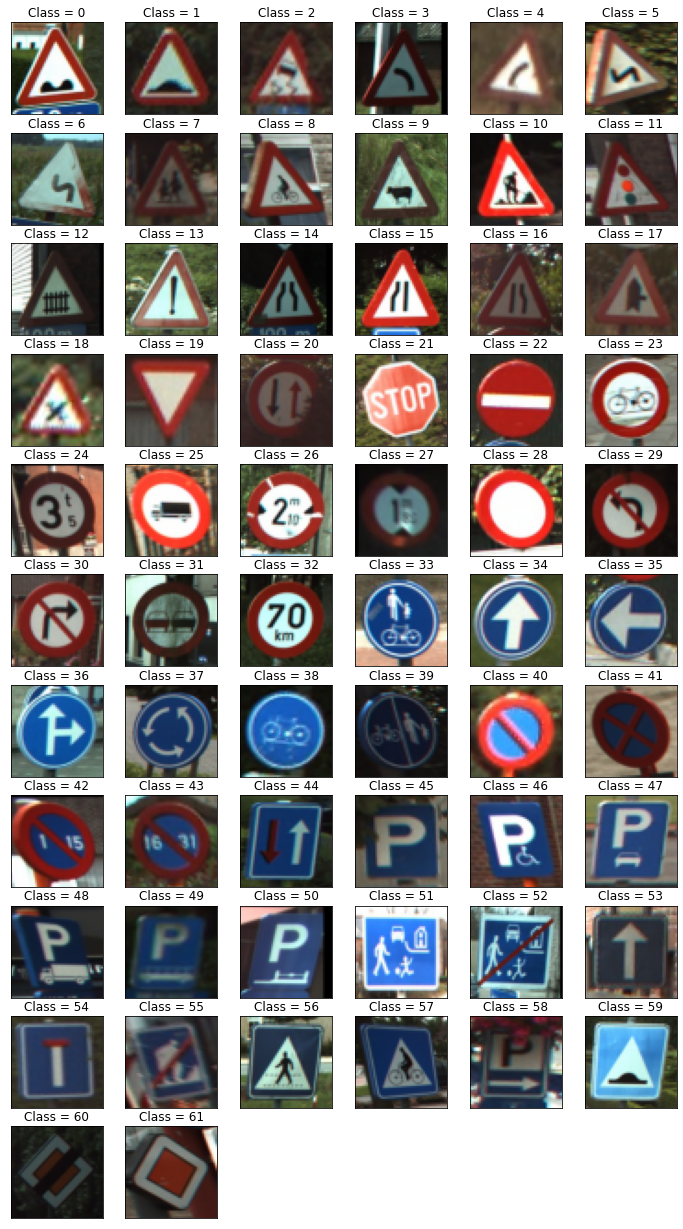

In [5]:
# Show sample for each class.
class_labels = set(np.unique(y_train))
n_classes = len(class_labels)

n_cols = 6
n_rows = n_classes // n_cols + 1
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
for label in sorted(class_labels):
    row = label // n_cols
    col = label % n_cols
    img_idx = np.argmax(y_train == label)
    ax[row, col].imshow(X_train[img_idx])
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])
    ax[row, col].set_title(f'Class = {label}')
    
leftover_subplots = n_cols - (max(class_labels) % n_cols) - 1
for i in range(leftover_subplots):
    fig.delaxes(ax[-1, -(i+1)])

In [6]:
from sklearn.linear_model import LinearRegression

# Define hyperparameters
batch_size = 64
learning_rate = 0.01
epochs = 25
in_features = 5
out_features = 1

def train_model(model, dataset, learning_rate, batch_size, epochs): 
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) #ToDo: lr scheduler instead of lr fix

    # Train linear model using SGD on mini-batches.
    for epoch in range(epochs):
        # DataLoader generates random batches from a given dataset.
        data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)
         # We want to report the training loss after each epoch
        epoch_loss = 0.0 

        for batch in data_loader:
            # After each iteration of the training step, reset the local gradients stored in the network to zero.
            model.zero_grad()
            model.zero_grad()

            # Compute the forward pass.
            # Numpy uses doubles by default but Torch expects floats, since the added accuracy of doubles 
            # is generally not useful for neural networks.
            # We fix this issue by changing the datatype of 'X' and 'y' with the .float method.
            yhat = model.forward(batch['X'].float())

            # Compute the batch error.
            batch_loss = F.cross_entropy(yhat, batch['y'].long())
            epoch_loss += batch_loss.item()
            
            # Backpropagate the gradient and adjust the weights.
            batch_loss.backward()
            optimizer.step()
        
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss}')

def mse(model, X_test, y_test):
    X_test = torch.from_numpy(X_test).float()    
    yhat = model.forward(X_test).detach().numpy()
    mse = np.mean(np.power(yhat - y_test, 2))
    print('Test MSE:', mse)

In [7]:
# Implement your evaluation here.
def get_confusion_matrix(y_pred, y_true, n_classes):
    assert len(y_pred) == len(y_true)
    results = np.zeros(shape=(n_classes, n_classes))
    for i in range(len(y_pred)):
        results[y_pred[i], y_true[i]] += 1
    return results
    
def precision(y_pred, y_true, n_classes):
    precision = np.zeros(shape=n_classes)
    confusion_matrix = get_confusion_matrix(y_pred, y_true, n_classes)
    for i in range(n_classes):
        sum_of_row = confusion_matrix[i].sum()
        if confusion_matrix[i, i] != 0:
            precision[i] = confusion_matrix[i, i] / sum_of_row
    return precision

def recall(y_pred, y_true, n_classes):
    recall = np.zeros(shape=n_classes)
    confusion_matrix = get_confusion_matrix(y_pred, y_true, n_classes)
    for i in range(n_classes):
        sum_of_column = confusion_matrix[:,i].sum()
        if confusion_matrix[i, i] != 0:
            recall[i] = confusion_matrix[i, i] / sum_of_column
    return recall

def f1score(y_pred, y_true, n_classes):
    p = precision(y_pred, y_true, n_classes)
    r = recall(y_pred, y_true, n_classes)
    f1 = np.zeros(shape=n_classes)
    for i in range(n_classes):
        if r[i] + p[i] != 0:
            f1[i] = 2 * p[i] * r[i] / (r[i] + p[i])
    return f1

In [8]:
# Implement your model and training here.
def swap_data(X):
    X1 = np.swapaxes(X, 1, 3)
    X2 = np.swapaxes(X1, 2, 3)
    return X2

learning_rate = 0.001

net_array = []
net_array.append(nn.Conv2d(3, 32, kernel_size=3, padding=1))
net_array.append(nn.ReLU())
net_array.append(nn.MaxPool2d((2, 2)))

net_array.append(nn.Conv2d(32, 128, kernel_size=3, padding=1))
net_array.append(nn.ReLU())
net_array.append(nn.MaxPool2d((2, 2)))

net_array.append(nn.Flatten())
net_array.append(nn.Linear(128 * 12 * 12, n_classes))
net_array.append(nn.Softmax())

model = nn.Sequential(*net_array)

X_test_tensor = torch.from_numpy(swap_data(X_test)).float()
model.forward(X_test_tensor) #test dimensionality

X_train_tensor = torch.tensor(swap_data(X_train)).float()
y_train_tensor = torch.tensor(y_train).long()
dataset_train = BasicDataset(X_train_tensor, y_train_tensor)
train_model(model, dataset_train, learning_rate, batch_size, epochs=1)
print()

C:\Users\robin\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
C:\Users\robin\anaconda3\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\robin\anaconda3\lib\site-packages\torch\autograd\__init__.py:147: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version

Epoch 1/1 - Loss: 273.78327894210815



In [9]:
# Implement your evaluation here.
X_test_tensor = torch.from_numpy(swap_data(X_test)).float()
yhat = model.forward(X_test_tensor).detach().numpy()
print(yhat.shape)
y_pred = np.argmax(yhat, axis=1)
print(y_pred.shape)

p = precision(y_pred, y_test, n_classes)
#print('precision:', p)
r = recall(y_pred, y_test, n_classes)
#print('recall:', r)
f1 = f1score(y_pred, y_test, n_classes)
#print('f1:', f1)

(2520, 62)
(2520,)


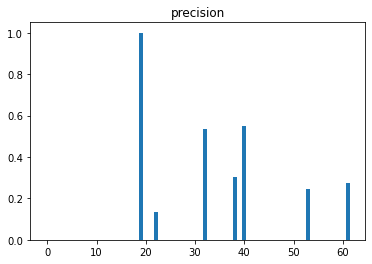

In [10]:
plt.bar(np.arange(n_classes), p)
plt.title('precision')
plt.show()

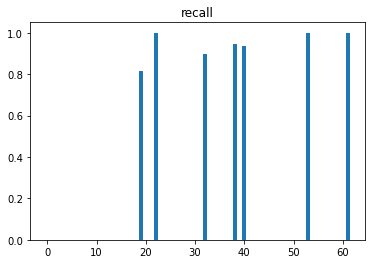

In [11]:
plt.bar(np.arange(n_classes), r)
plt.title('recall')
plt.show()

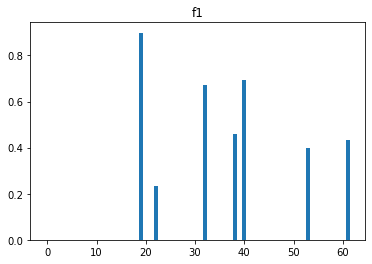

In [12]:
plt.bar(np.arange(n_classes), f1)
plt.title('f1')
plt.show()

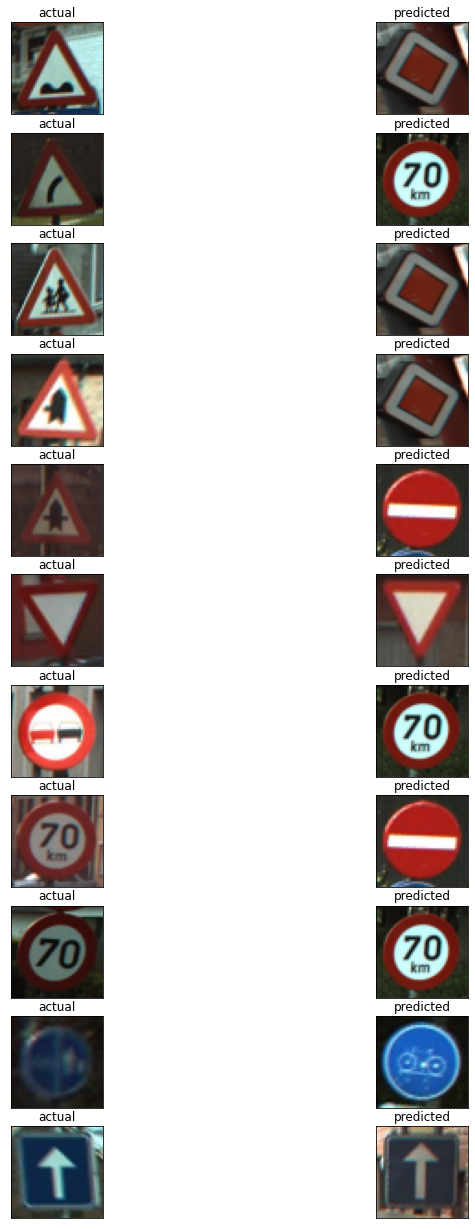

In [13]:
#Example Predictions

list_of_examples = [0, 50, 69, 333, 420, 666, 1000, 1111, 1234, 2000, 2222]
fig, ax = plt.subplots(len(list_of_examples), 2, figsize=(n_cols*2, n_rows*2))
for i in range(len(list_of_examples)):
    #print(list_of_examples[i])
    row = i
    col = 0
    ax[row, col].imshow(X_test[list_of_examples[i]])
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])
    ax[row, col].set_title('actual')
    
    label = y_pred[list_of_examples[i]]
    img_idx = np.argmax(y_train == label)
    col = 1
    ax[row, col].imshow(X_train[img_idx])
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])
    ax[row, col].set_title('predicted')

## Resnet Testing

In [14]:
from torchvision import models

resnet = models.resnet18(pretrained=False)
in_ftr = resnet.fc.in_features
out_ftr = n_classes
resnet.fc = nn.Linear(in_ftr,out_ftr,bias=True)
yhat = resnet.forward(X_test_tensor).detach().numpy()
print(yhat.shape)
train_model(model, dataset_train, learning_rate, batch_size, epochs=1)

(2520, 62)
Epoch 1/1 - Loss: 263.50131154060364


In [15]:
# Implement your evaluation here.
X_test_tensor = torch.from_numpy(swap_data(X_test)).float()
yhat = resnet.forward(X_test_tensor).detach().numpy()
print(yhat.shape)
y_pred = np.argmax(yhat, axis=1)
print(y_pred.shape)

p = precision(y_pred, y_test, n_classes)
#print('precision:', p)
r = recall(y_pred, y_test, n_classes)
#print('recall:', r)
f1 = f1score(y_pred, y_test, n_classes)
#print('f1:', f1)

(2520, 62)
(2520,)


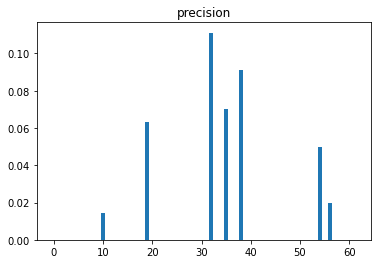

In [16]:
plt.bar(np.arange(n_classes), p)
plt.title('precision')
plt.show()

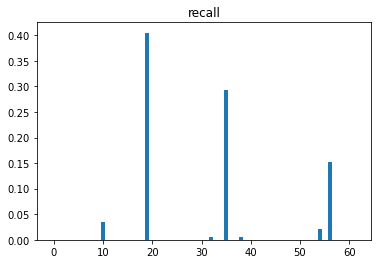

In [17]:
plt.bar(np.arange(n_classes), r)
plt.title('recall')
plt.show()

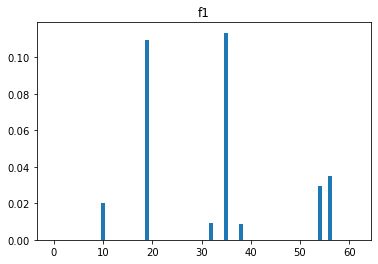

In [18]:
plt.bar(np.arange(n_classes), f1)
plt.title('f1')
plt.show()

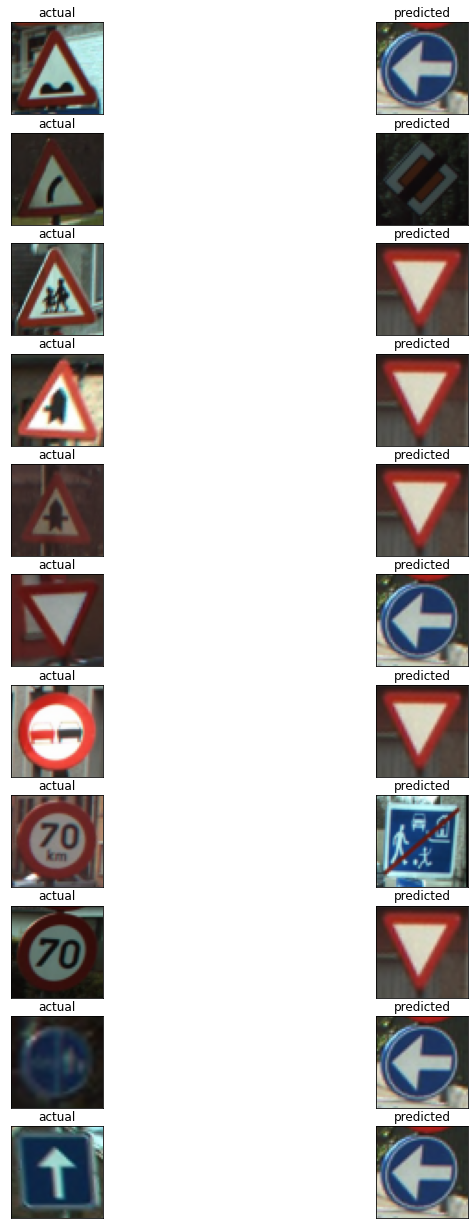

In [19]:
#Example Predictions

list_of_examples = [0, 50, 69, 333, 420, 666, 1000, 1111, 1234, 2000, 2222]
fig, ax = plt.subplots(len(list_of_examples), 2, figsize=(n_cols*2, n_rows*2))
for i in range(len(list_of_examples)):
    #print(list_of_examples[i])
    row = i
    col = 0
    ax[row, col].imshow(X_test[list_of_examples[i]])
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])
    ax[row, col].set_title('actual')
    
    label = y_pred[list_of_examples[i]]
    img_idx = np.argmax(y_train == label)
    col = 1
    ax[row, col].imshow(X_train[img_idx])
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])
    ax[row, col].set_title('predicted')

In [20]:
import torchvision.datasets as datasets

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

C:\Users\robin\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [21]:
print(mnist_trainset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train


## ToDo: number of classes as output dimensions

In [22]:
#convert grey scale image to RGB for compatibility with resnet architecture

X_train_grey = mnist_trainset.train_data
X_train_helper = torch.unsqueeze(X_train_grey, 1)
X_train = X_train_helper.repeat(1, 3, 1, 1).float()
y_train = mnist_trainset.train_labels
print(X_train.shape)
print(y_train.shape)

C:\Users\robin\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 3, 28, 28])
torch.Size([60000])


C:\Users\robin\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [23]:
dataset_train = BasicDataset(X_train, y_train)
train_model(resnet, dataset_train, learning_rate, batch_size, epochs=1)

Epoch 1/1 - Loss: 126.34319770033471


In [24]:
import torchvision.datasets as datasets

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)